# Machine Learning for Bank Customer Churn Prediction

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
* [4. Preprocessing](#pre)
* [5. Model Training and Validation](#train)
	* [5.1. First Model](#1)
	* [5.2. Second Model](#2)
	* [5.3. Sanity Check](#3)
	* [5.4. Confusion Matrix](#4)
	* [5.5. Third Model Using Balanced Class Weight](#5)
	* [5.6. Fourth Model Using Upsampling](#6)
	* [5.7. Fifth Model Using Downsampling](#7)
	* [5.8. Adjusting Classification Thresholds](#8)
	* [5.9. Precision Recall Curve](#9)
	* [5.10. Receiver Operating Characteristic Curve](#10)
* [6. General Conclusion](#end)

## 1. Introduction <a id='intro'></a>

### 1.1. Project Description

Bank Beta customers are gradually leaving the company, their numbers are decreasing every month. Bank employees realize that it would be more cost-effective for the company to focus on retaining their loyal customers rather than attracting new ones.

In this case, our task is to predict whether a customer will soon leave the bank or not. You have data related to the clients' behavior in the past and their history of contract termination with the bank.

Create a model with the maximum possible F1 score. To pass the review, you need a minimum F1 score of 0.59 for the test dataset. Check the F1 score for the test set.

Additionally, measure the AUC-ROC metric and compare it with the F1 score.

### 1.2. Objectives

The objectives for this research are:
1. Build first model without adjusting for imbalance.
2. Conduct sanity check.
3. Improve the model until the F1 score is more than equals to 0.59.

### 1.3. Dataset Description

The dataset contains:
* RowNumber - observation number
* CustomerId - customer id
* Surname - surname
* CreditScore - credit score
* Geography - domicile country
* Gender - gender
* Age - age
* Tenure - maturity period for the customer's fixed deposit
* Balance - account balance
* NumOfProducts - number of bank's products used by the customer
* HasCrCard - credit card availability (1 - yes; 0 - no)
* IsActiveMember - active membership (1 - yes; 0 - no)
* EstimatedSalary - estimated salary
* Exited - has the customer leave (1 - yes; 0 - no)

### 1.4. Methodology

The steps for this research are:
1. Data exploration
2. Data preprocessing
3. Model training and validation
4. Conclusion

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('datasets/Churn.csv', index_col='RowNumber')

[back to table of contents](#back)

## 3. Data Overview <a id='overview'></a>

In [3]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


We can see that the dataset has 10,000 rows and 13 columns. All of the columns in the dataset have appropriate datatypes. There is no redundant columns. However there are 909 rows with missing `Tenure` values.

In [5]:
data[data['Tenure'].isnull()].head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


In [6]:
data.loc[data['Tenure'].notnull(),'Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

Observations with tenure equals to NaN seems to be because the customer doesn't have any fixed deposit. Therefore, we will set those values to 0.

In [7]:
data.duplicated().sum()

0

There is no duplicated data in the dataset.

In [8]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


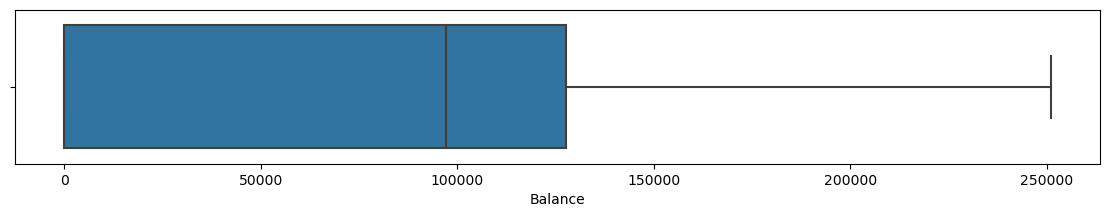

In [9]:
plt.figure(figsize=(14,2))
sns.boxplot(data=data, x='Balance')
plt.show()

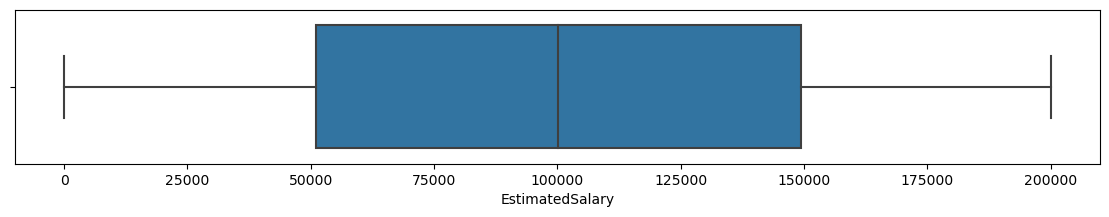

In [10]:
plt.figure(figsize=(14,2))
sns.boxplot(data=data, x='EstimatedSalary')
plt.show()

The center and dispersion of the data seems to be reasonable.

[back to table of contents](#back)

## 4. Preprocessing <a id='pre'></a>

### 4.1. Handling Missing Values

As previously stated, we will fill missing values in `Tenure` column with 0.

In [11]:
data['Tenure'].fillna(0, inplace=True)

### 4.2. Defining Features and Target Columns

Because `Customerid` and `Surname` are unique identifiers of the customers, we will not use these as features for the ML model. The features for the model are all of the columns except `Customerid`, `Surname`, and `Exited` columns. Whereas the target is the `Exited` column.

In [12]:
features = data.drop(['CustomerId','Surname','Exited'], axis=1)
target = data['Exited']

Split the data into training dataset and validation dataset

In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=123)

features_train.shape, features_valid.shape, target_train.shape, target_valid.shape

((7500, 10), (2500, 10), (7500,), (2500,))

Define numerical and categorical columns.

In [14]:
numerical = ['CreditScore', 'Age', 'Tenure', 'Balance',\
             'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical = ['Geography', 'Gender']

### 4.3. Data Transformation

#### 4.3.1. One Hot Encoding for Categorical Data

We will transform categorical data into numerical by using dummy columns and remove the first column so that the resulting columns are not redundant and prevent multicollinearity.

In [15]:
features_train = pd.get_dummies(features_train, columns=categorical, drop_first=True)
features_valid = pd.get_dummies(features_valid, columns=categorical, drop_first=True)

#### 4.3.2. Feature Scaling

We will then standardize the numerical data so that the scale is comparable between each other.

In [16]:
scaler = StandardScaler()
features_train[numerical] = scaler.fit_transform(features_train[numerical])
features_valid[numerical] = scaler.transform(features_valid[numerical])

#### 4.3.3. Check Final Features

In [17]:
features_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
9175,-1.251581,2.091987,-1.130215,-1.215055,0.794902,0.647388,0.972122,1.590503,0,0,1
4380,0.196946,-0.935052,0.794538,-1.215055,0.794902,0.647388,0.972122,0.665504,0,0,1
542,-0.289345,-1.218837,-1.451007,-1.215055,0.794902,0.647388,0.972122,0.927786,0,0,1
7252,0.766010,-0.745862,-1.451007,0.985079,-0.919727,0.647388,-1.028678,-1.510774,1,0,1
1136,0.859130,-0.745862,0.473746,1.297580,0.794902,-1.544670,-1.028678,1.358040,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9786,-2.017232,-1.124242,0.152954,1.267134,0.794902,-1.544670,-1.028678,-0.505325,0,0,0
7764,-0.372118,-0.272888,-1.130215,-0.513534,-0.919727,0.647388,0.972122,-0.460937,0,1,0
5219,0.362492,-1.786407,-0.167838,0.452485,0.794902,0.647388,-1.028678,-1.062903,0,0,1


In [18]:
features_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
2657,1.335075,-0.462078,0.152954,-1.215055,0.794902,-1.544670,0.972122,0.205502,0,1,0
446,1.014329,-1.218837,-1.130215,0.023503,-0.919727,-1.544670,0.972122,1.445883,0,0,0
9506,0.010707,-1.029647,1.756914,0.051890,-0.919727,0.647388,0.972122,-0.437331,0,0,1
333,0.134866,0.483872,-0.809422,0.648486,0.794902,-1.544670,0.972122,0.779068,1,0,1
4169,-1.386088,-0.178293,1.115330,-1.215055,-0.919727,0.647388,-1.028678,0.034458,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
398,-1.065342,-0.651268,1.115330,1.264709,-0.919727,0.647388,-1.028678,-0.557200,1,0,1
5553,-0.237612,0.200087,-0.488630,-1.215055,0.794902,0.647388,-1.028678,0.571209,0,0,1
1454,0.227986,1.335227,0.794538,-1.215055,-0.919727,0.647388,0.972122,0.644033,0,0,0


[back to table of contents](#back)

## 5. Model Training and Validation <a id='train'></a>

### 5.1. First Model <a id='1'></a>

We will build model using Random Forest algorithm.

In [19]:
best_model1 = 0
best_model1_score = 0
best_model1_depth = 0
best_model1_est = 0
best_predicted_valid1 = 0

for est in range(1,51,10):
    for depth in range(1,21):
        model1 = RandomForestClassifier(random_state=123, max_depth=depth, n_estimators=est)
        model1.fit(features_train, target_train)
        predicted_valid1 = pd.Series(model1.predict(features_valid), index=target_valid.index)
        acc_score1 = accuracy_score(target_valid, predicted_valid1)
        if acc_score1 > best_model1_score :
            best_model1 = model1
            best_model1_score = acc_score1
            best_model1_depth = depth
            best_model1_est = est
            best_predicted_valid1 = predicted_valid1
            
f'Accuracy score = {best_model1_score}, depth = {best_model1_depth}, n_estimators = {best_model1_est}'

'Accuracy score = 0.8628, depth = 20, n_estimators = 31'

We achieve 86% accuracy score with depth equals to 20 and n_estimators equals to 31. It is highly likely that the classes are imbalanced.

[back to table of contents](#back)

### 5.2. Second Model <a id='2'></a>

Next, we will build a model using Logistic Regression algorithm.

In [20]:
model2 = LogisticRegression(random_state=123, solver='liblinear')
model2.fit(features_train, target_train)
predicted_valid2 = pd.Series(model2.predict(features_valid), index=target_valid.index)
acc_score2 = accuracy_score(target_valid, predicted_valid2)

In [21]:
acc_score2

0.8136

With logistic regression, we also get a high accuracy score of 81%.

[back to table of contents](#back)

### 5.3. Sanity Check <a id='3'></a>

Based on previous result, we will then conduct sanity check to check whether the target values relative frequency are balanced or not.

Target dataset sanity check:

In [22]:
class_frequency = target.value_counts()/len(target)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

First model prediction values sanity check.

In [23]:
class_frequency = predicted_valid1.value_counts()/len(predicted_valid1)
class_frequency

0    0.8664
1    0.1336
dtype: float64

Second model prediction values sanity check.

In [24]:
class_frequency = predicted_valid2.value_counts()/len(predicted_valid2)
class_frequency

0    0.926
1    0.074
dtype: float64

The first and second model has the tendency to put the label 0 to the target.

We will try to build constant model to compare with random forest and logistic regression model.

In [25]:
target_pred_constant = pd.Series(0, index=target_valid.index)
accuracy_score(target_valid, target_pred_constant)

0.7932

As we can see, the constant model can produce result as good as the model trained with logistic regression algorithm and the relative frequency between 0 and 1 are not balanced. Therefore, this model **doesn't pass** sanity check.

[back to table of contents](#back)

### 5.4. Confusion Matrix <a id='4'></a>

We will now build confusion matrix to check number of TP, TN, FP, and FN.

In [26]:
print(confusion_matrix(target_valid, predicted_valid1))

[[1899   84]
 [ 267  250]]


Based on the first model's prediction, there are more false negative than false positive. Therefore, the recall score for this model will be lower than precision.

In [27]:
precision_score(target_valid, predicted_valid1)

0.7485029940119761

In [28]:
recall_score(target_valid, predicted_valid1)

0.4835589941972921

In [29]:
f1_score(target_valid, predicted_valid1)

0.5875440658049355

The first model get us 58% F1 score with 74.8% precision and 48.4% recall score.

[back to table of contents](#back)

### 5.5. Third Model Using Balanced Class Weight <a id='5'></a>

For this method, we will modify the hyperparameter from the first model.

In [30]:
model3 = RandomForestClassifier(random_state=123, max_depth=20, n_estimators=31, class_weight='balanced')
model3.fit(features_train, target_train)
predicted_valid3 = pd.Series(model3.predict(features_valid), index=target_valid.index)
acc_score3 = accuracy_score(target_valid, predicted_valid3)
f1_score3 = f1_score(target_valid, predicted_valid3)
acc_score3, f1_score3

(0.8572, 0.5744934445768772)

This model is slightly worse than the previous model with the accuracy of 86.2% and F1 score of 58.4%.

[back to table of contents](#back)

### 5.6. Fourth Model Using Upsampling <a id='6'></a>

We will use the data with 1 label as its target 4 times so that the counts between 0 and 1 as target are roughly equal.

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)
    return features_upsampled, target_upsampled

In [32]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [33]:
class_frequency = target_train_upsampled.value_counts()/len(target_train_upsampled)
class_frequency

1    0.504146
0    0.495854
Name: Exited, dtype: float64

We use the algorithm and hyperparameter from the first model and the resulting upsamples to train the model.

In [34]:
model4 = RandomForestClassifier(random_state=123, max_depth=20, n_estimators=31)
model4.fit(features_train_upsampled, target_train_upsampled)
predicted_valid4 = model4.predict(features_valid)
acc_score4 = accuracy_score(target_valid, predicted_valid4)
f1_score4 = f1_score(target_valid, predicted_valid4)

acc_score4, f1_score4

(0.854, 0.6233230134158927)

We get a slightly better F1 score of 62.3% and the same accuracy score of 85.4%.

[back to table of contents](#back)

### 5.7. Fifth Model Using Downsampling <a id='7'></a>

We will use the data with 0 as its target 0.25 times so that the counts between 0 and 1 as target are roughly equal.

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=123)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=123)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=123)
    return features_downsampled, target_downsampled

In [36]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

In [37]:
class_frequency = target_train_downsampled.value_counts()/len(target_train_downsampled)
class_frequency

1    0.504146
0    0.495854
Name: Exited, dtype: float64

We use the algorithm and hyperparameter from the first model and the resulting upsamples to train the model.

In [38]:
model5 = RandomForestClassifier(random_state=123, max_depth=20, n_estimators=31)
model5.fit(features_train_downsampled, target_train_downsampled)
predicted_valid5 = model5.predict(features_valid)
acc_score5 = accuracy_score(target_valid, predicted_valid5)
f1_score5 = f1_score(target_valid, predicted_valid5)

acc_score5, f1_score5

(0.7752, 0.5855457227138643)

The resulting model from this downsampling method performs worse than the first model. It has the accuracy score of 77.5% and F1 score of 58.5%.

[back to table of contents](#back)

### 5.8. Adjusting Classification Thresholds <a id='8'></a>

We will modify the current best model, the fourth model.

In [39]:
probabilities_valid = model4.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
probabilities_one_valid[:5]

array([0.        , 0.19354839, 0.03511637, 0.51612903, 0.5483871 ])

In [40]:
for threshold in np.arange(0.40,0.55,0.01):
    predicted_valid6 = probabilities_one_valid > threshold
    accuracy = accuracy_score(target_valid, predicted_valid6)
    precision = precision_score(target_valid, predicted_valid6)
    recall = recall_score(target_valid, predicted_valid6)
    f1 = f1_score(target_valid, predicted_valid6)
    print(f'Threshold = {threshold:.2f} | Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}')

Threshold = 0.40 | Accuracy = 0.836, Precision = 0.593, Recall = 0.667, F1 = 0.628
Threshold = 0.41 | Accuracy = 0.838, Precision = 0.596, Recall = 0.667, F1 = 0.630
Threshold = 0.42 | Accuracy = 0.844, Precision = 0.618, Recall = 0.638, F1 = 0.628
Threshold = 0.43 | Accuracy = 0.844, Precision = 0.618, Recall = 0.638, F1 = 0.628
Threshold = 0.44 | Accuracy = 0.845, Precision = 0.623, Recall = 0.638, F1 = 0.630
Threshold = 0.45 | Accuracy = 0.847, Precision = 0.629, Recall = 0.632, F1 = 0.631
Threshold = 0.46 | Accuracy = 0.853, Precision = 0.652, Recall = 0.617, F1 = 0.634
Threshold = 0.47 | Accuracy = 0.853, Precision = 0.653, Recall = 0.615, F1 = 0.633
Threshold = 0.48 | Accuracy = 0.852, Precision = 0.652, Recall = 0.609, F1 = 0.630
Threshold = 0.49 | Accuracy = 0.854, Precision = 0.668, Recall = 0.584, F1 = 0.623
Threshold = 0.50 | Accuracy = 0.854, Precision = 0.668, Recall = 0.584, F1 = 0.623
Threshold = 0.51 | Accuracy = 0.854, Precision = 0.668, Recall = 0.580, F1 = 0.621
Thre

When threshold equals to 0.46, the model achieve its best F1 score of 63.4% with the accuracy of 85.3%, precision of 65.2% and recall of 61.7%.

[back to table of contents](#back)

### 5.9. Precision Recall Curve <a id='9'></a>

In [41]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)

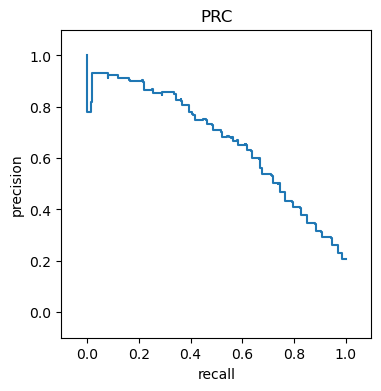

In [42]:
fig, ax = plt.subplots(figsize=(4,4))
ax.step(recall, precision, where='post')
ax.set_title('PRC')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.axis([-0.1,1.1,-0.1,1.1])
plt.show()

From this curve, we can see that recall and precision has negative correlation. The two values will be balanced at around 0.6 precision and recall scores.

[back to table of contents](#back)

### 5.10. Receiver Operating Characteristic Curve <a id='10'></a>

In [43]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

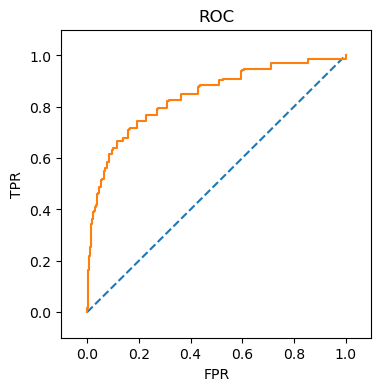

In [44]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0,1],[0,1],'--')
ax.step(fpr, tpr, where='post')
ax.set_title('ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.axis([-0.1,1.1,-0.1,1.1])
plt.show()

In [45]:
print(roc_auc_score(target_valid, probabilities_one_valid))

0.8482088077478686


From ROC Curve, we see that for different thresholds, the TPR score drastically gets better from 0% to 70%, afterwards the rate slowly gets better. The ROC-AUC score (84.8%) is way better than the random model AUC score (50%). This means that our fourth model is better than a random model.

[back to table of contents](#back)

## 6. Result and Conclusion <a id='end'></a>

Based on the initial data exploration, we found that the data is only missing on `tenure` column. There is no redundant columns, duplicated rows, invalid data, or outliers. The missing data is handled by filling in with the value 0.

After cleaning the data, it is then pre-processed by defining features and target columns. The feature columns consist of `CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, and EstimatedSalary` columns. Whereas the target column is `Exited` column. After defining the features and target columns, the data is then split into training and validation dataset with 75% of the data goes to training dataset and the remaining goes to validation dataset.

The features are divided into numerical and categorical columns with Geography and Gender columns put into categorical and the remaining put into numerical. For the following analysis, we transform the categorical data using **one hot encoding** by generating dummy columns so that each value in the categorical columns has its own column indicating the existence of that value. The numerical columns are also transformed by **standardizing** the value so that each column has the mean of 0 and standard deviation of 1. This standardization puts every value in the columns into the same scale.

Next, we build an initial model using random forest classifier using a number of different depths and estimators to pick the best. The best model gives the accuracy score of 86.2% with the depth of 20, and n_estimators of 31. After that we build the second model using logistic regression. This model has a worse accuracy score of 81.4%. With a high accuracy score. It is highly likely that the class is imbalanced so we perform sanity check. Based on the sanity check, we see that 79.6% of the target column is 0 and 20.4% is 1. This is **highly imbalanced**. We then build the confusion matrix and calculate precision, recall, and F1 score. We get the precision of 74.8%, recall, of 48.4% and F1 score of 58%.

We build the third model using the balanced class weight hyperparameter which gives the same accuracy score of 86.2% and F1 score of 58.4%. In the fourth model, we try to balance the class by upsampling the training dataset with 1 value 4 times. Then we train the first model with this dataset. From this model, we also get the 85.4% for the accuracy score and 62.3% for the f1 score. **This model is currently the best model**. The fifth model is built by downsampling the dataset with 0 value by 0.25 times. This model gives off a worse accuracy of 77.5% and f1 score of 58.5%.

Next, we try to adjust the classification threshold for the fourth model. When the threshold equals to **0.46**, the model achieves its best state with the accuracy of 85.3%, precision of 65.2% and recall of 61.7%. We then plot the precision recall curve for this model. The plot suggest that the two values will be **balanced** at around 60% precision and recall scores. From ROC Curve, we see that for different thresholds, the TPR score drastically gets better from 0% to 70%, afterwards the rate slowly gets better. The ROC AUC score from this curve is **84.8%** which is better than a random model.

Based on the accuracy and F1 score, we can get the **best prediction** with accuracy score of 85.3% and F1 score of 63.4% when we use upsamples to train random forest classifier with the depth of 20, and n_estimators of 31 with threshold adjustment to 0.46.

[back to table of contents](#back)